In [1]:
import re
import os
import json

In [2]:
load_tests("./data/mold_test_imgs/")

NameError: name 'load_tests' is not defined

In [3]:
import configparser

# Loads the config file passed in as a parameter
def load_config(config_file):
    config = configparser.ConfigParser()
    config.read(config_file)
    return config

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
cmaps = ['gray', 'blue']
chs = [1,2,3,4,5]
if len(cmaps) < len(chs):
    cmaps += [cmaps[-1]] * (len(chs) - len(cmaps))
cmaps

['gray', 'blue', 'blue', 'blue', 'blue']

In [12]:
from importlib import reload
import encasm.env
reload(encasm.env)
from encasm.env import PetriDish

In [13]:
test_env = PetriDish.from_config_file("test", "./encasm/configs/default_config.ini")

In [14]:
import scipy.signal as signal

import utils.videowriter
reload(utils.videowriter)
from utils.videowriter import VideoWriter
import encasm
reload(encasm)
import encasm.eval
reload(encasm.eval)
from encasm.eval import load_tests

data_dir = "./encasm/example_networks/"
test_envs = load_tests(folder = data_dir)

import encasm.env
reload(encasm.env)
from encasm.env import PetriDish


In [15]:
# applies a 2d convolution to the grid using scipy and the given kernel
def convolve(grid, kernel):
    return signal.convolve2d(grid, kernel, mode='same', boundary='fill', fillvalue=0)

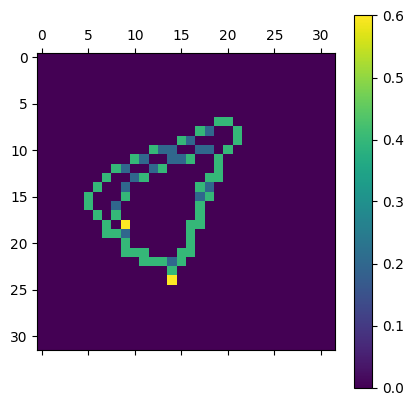

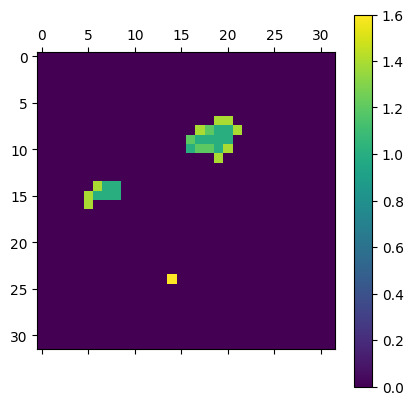

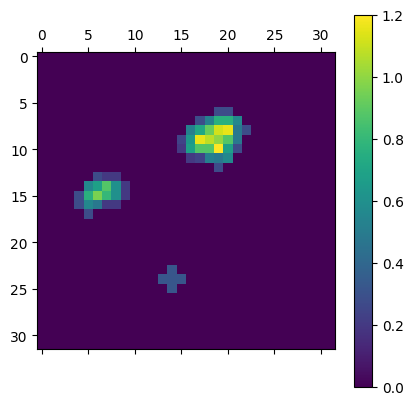

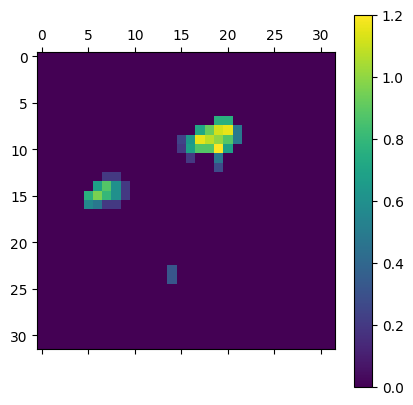

In [16]:


kernel = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
# Represents the percentage of nutrients lost to diffusion outside of the road network
edge_reinforcer = convolve(tenv.life == 0, kernel) * tenv.life*0.2
kernel[1,1] = 1
kernel = kernel * 0.2
plt.matshow(edge_reinforcer)
plt.colorbar()
# shows result in between each step
tenv.resv += tenv.resv * edge_reinforcer # Nutrients that would leave the cell stays in
plt.matshow(tenv.resv)
plt.colorbar()

diffused = convolve(tenv.resv, kernel)
plt.matshow(diffused)
plt.colorbar()
tenv.resv = diffused*tenv.life
plt.matshow(tenv.resv)
plt.colorbar()

In [17]:
def diffuse(r,l):
    l = l>0 # convert to boolean in case it isn't

    kernel = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
    # plt.matshow(r)
    # plt.colorbar()
    # print(r.sum())
    free_cells = (r<0.7) & l # A free cell is alive and isn't full of nutrients
    sources = r > 0.7 # purely cells that are full

    # How large of an area could a cell's resevoir flow to
    flow_area = convolve(free_cells, kernel) * l
    flow_area[l] += 1 # every cell includes itself

    # Nonzero just avoids divide by zero, this is just 5/flow_area * r, which is the adjusted nutrients 
    # to "bounce back" diffusion off of full cells and voids
    to_diff = np.divide(5., flow_area, out=np.zeros_like(r), where=flow_area!=0) * r

    kernel[1,1] = 1
    kernel = kernel * 0.2
    sinks = convolve(to_diff, kernel) * free_cells # sinks serve as sources to other sinks too


    # creates an array where free_cells have the value of sinks and sources have the value of to_diff * 0.2
    diffused = np.zeros_like(r)
    diffused[free_cells] = sinks[free_cells]
    diffused[sources] = to_diff[sources] * 0.2
    # plt.matshow(diffused)
    # plt.colorbar()
    # print(diffused.sum())
    return diffused

In [165]:
# tenv = PetriDish.from_env("tenv", test_envs["small"]['3']['1'])
# tenv.resv += tenv.food

# an 8 by 8 array representing an elbow bend road of life
l = np.array([[0,1,1],
              [0,1,1],
              [0,1,0]], dtype=np.float32)
r = np.array([[0,1,1],
              [0,1,0],
              [0,0,0]], dtype=np.float32)


In [185]:

# diffuses 10 times and shows makes a video
with VideoWriter(filename="./encasm/results/diffusion.mp4", fps=100) as vw:
    for i in range(100):
        r = diffuse(r,l)
        vw.add_concat_grids([r,l], cols=2)

In [ ]:
tenv = PetriDish.from_env("tenv", test_envs["small"]['3']['1'])
tenv.resv += tenv.food

In [192]:
# Records a video of diffusion in tenv
with VideoWriter("./encasm/results/diffusion.mp4", fps=1) as vid:
    vid.add_concat_grids([tenv.resv], cols = 1)
    print(tenv.resv.sum())

    for i in range(100):
        # tenv.resv += tenv.resv * edge_reinforcer # Nutrients that would leave the cell stays in
        # diffused = convolve(tenv.resv, kernel)
        # tenv.resv = diffused*tenv.life
        # tenv.resv = np.clip(tenv.resv + tenv.food*0.1, 0, 1)
        tenv.resv = diffuse(tenv.resv, tenv.life)
        # sets 10% of all life cells to 0
        # tenv.resv[tenv.life.nonzero()] *= np.random.rand(*tenv.life[tenv.life.nonzero()].shape) > 0.001
        if i%1 == 0:
            vid.add_concat_grids([tenv.resv], cols = 1)
    print(tenv.resv.sum())

82.84535173304752
84.87771245026353


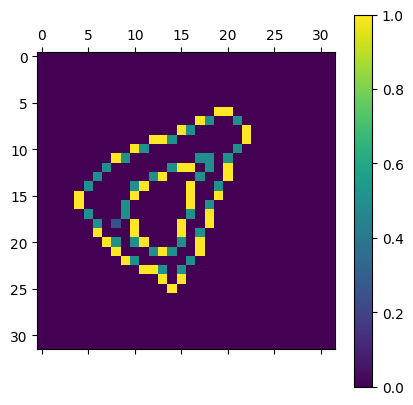

In [262]:
kernel = np.array([[0,1,0],[1,100,1],[0,1,0]])
edges = convolve(tenv.life, kernel)
edges[edges>100] = 0
edges[edges.nonzero()] = 1.0/edges[edges.nonzero()]
plt.matshow(edges)
plt.colorbar()

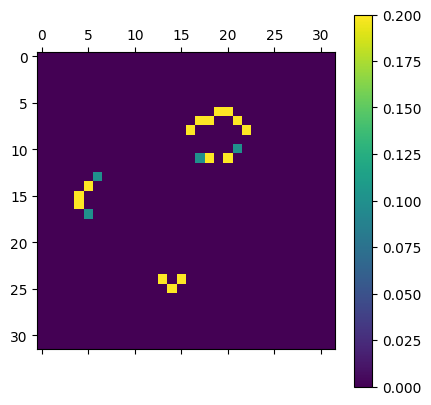

In [265]:
plt.matshow(edges*grid)
plt.colorbar()

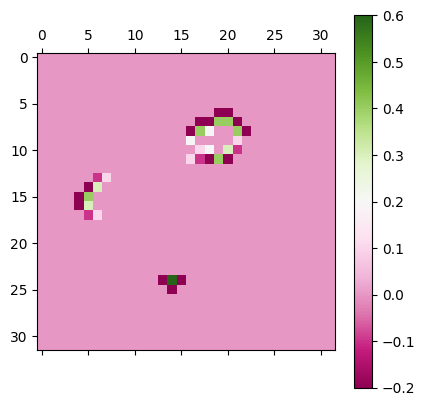

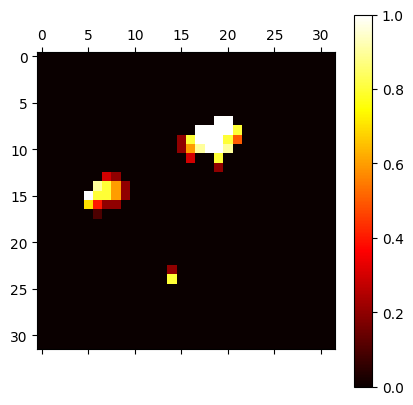

In [266]:
kernel = np.array([[0,0.2,0],[0.2,0.2,0.2],[0,0.2,0]])
plt.matshow(convolve(edges*grid*, kernel) * tenv.life + edges*grid*-1, cmap = "PiYG")
plt.colorbar()
newcombined = (grid + convolve(edges*grid*5, kernel)) * tenv.life
plt.matshow(newcombined, cmap='hot')
plt.colorbar()

In [313]:
tenv.life = np.ones_like(tenv.life)


In [314]:
# applies a 2d convolution to the grid using scipy and the given kernel
def convolve(grid, kernel):
    return signal.convolve2d(grid, kernel, mode='same', boundary='wrap')

def diffuse(grid, mask):
    kernel = np.array([[0,1,0],[1,100,1],[0,1,0]])
    edges = convolve(tenv.life, kernel)
    edges[edges>100] = 0
    edges[edges.nonzero()] = 1.0/edges[edges.nonzero()]

    kernel = np.array([[0,0.2,0],[0.2,0.2,0.2],[0,0.2,0]])
    diffused = convolve(tenv.resv, kernel)

    return (diffused + convolve(edges*diffused*5, kernel)) * mask

In [317]:
tenv.resv += tenv.food
with VideoWriter("./encasm/results/test.mp4", fps=30) as vid:
    for i in range(500):
        tenv.resv = np.clip(tenv.resv + tenv.food*1, 0, 100)
        tenv.resv = diffuse(tenv.resv, tenv.life)
        # sets 10 of resevoir cells to 0 randomly
        # tenv.resv[np.random.randint(0, tenv.resv.shape[0], 10), np.random.randint(0, tenv.resv.shape[1], 10)] = 0

        vid.add_concat_grids([tenv.food,tenv.life,tenv.resv])

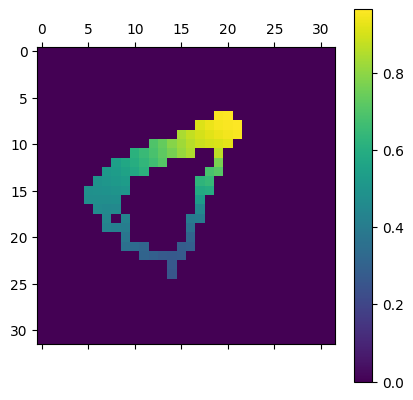

In [295]:
import io
from PIL import Image
plt.matshow(tenv.resv)
plt.colorbar()